## Описание проекта

Архитектура решения для распознавания рукописного текста на основе трансформаторов с легким конволюционным кодером. Гипотеза состоит в том, что простые кодировщики более точны в задачах HTR по сравнению с такими кодировщиками, как ResNet50. В этом блокноте показана реализация архитектуры:

![picture](https://github.com/conwerner/ocr-transformer/raw/master/diagram_model2.png)

github: https://github.com/conwerner/ocr-transformer

## Описание данных

In [1]:
from collections import Counter
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import cv2

# convert images and labels into defined data structures
def process_data(image_dir, labels_dir, ignore=[]):
    """
    params
    ---
    image_dir : str
      path to directory with images
    labels_dir : str
      path to tsv file with labels
    returns
    ---
    img2label : dict
      keys are names of images and values are correspondent labels
    chars : list
      all unique chars used in data
    all_labels : list
    """

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split('\t')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char)
        except:
            print('ValueError:', x)
            pass

    all_labels = list(img2label.values())
    chars.sort()

    return img2label, chars, all_labels


# GENERATE IMAGES FROM A FOLDER
def generate_images(img_paths):
    """
    params
    ---
    names : list of str
        paths to images
    returns
    ---
    data_images : list of np.array
        images in np.array format
    """
    data_images = []
    for path in tqdm(img_paths):
        img = cv2.imread(path)
        try:
            data_images.append(img.astype('uint8'))
        except:
            img = process_image(img)
    return data_images

In [ ]:
TRAIN_IMAGE_DIR = '../input/cyrillic-handwriting-dataset/train/'
TRAIN_LABELS_DIR = '../input/cyrillic-handwriting-dataset/train.tsv'

TEST_IMAGE_DIR = '../input/cyrillic-handwriting-dataset/test/'
TEST_LABELS_DIR = '../input/cyrillic-handwriting-dataset/test.tsv'

img2label_train, chars_train, all_words_train = process_data(TRAIN_IMAGE_DIR, TRAIN_LABELS_DIR)  # TRAIN PART
img2label_test, chars_test, all_words_test = process_data(TEST_IMAGE_DIR, TEST_LABELS_DIR)  # TEST PART

img2label = {**img2label_train, **img2label_test} # MERGE
chars = chars_train + chars_test

image_names, labels = list(img2label.keys()), [img2label[key] for key in img2label.keys()]

images = generate_images(image_names)

Size of dataset: 73830
Max length of expression: 40
The most common char: ('о', 56735)
The least common char: ('x', 1)
The most common expression: ('что', 351)
The least common expression: ('продолжила борьбу', 1)


<BarContainer object of 107 artists>

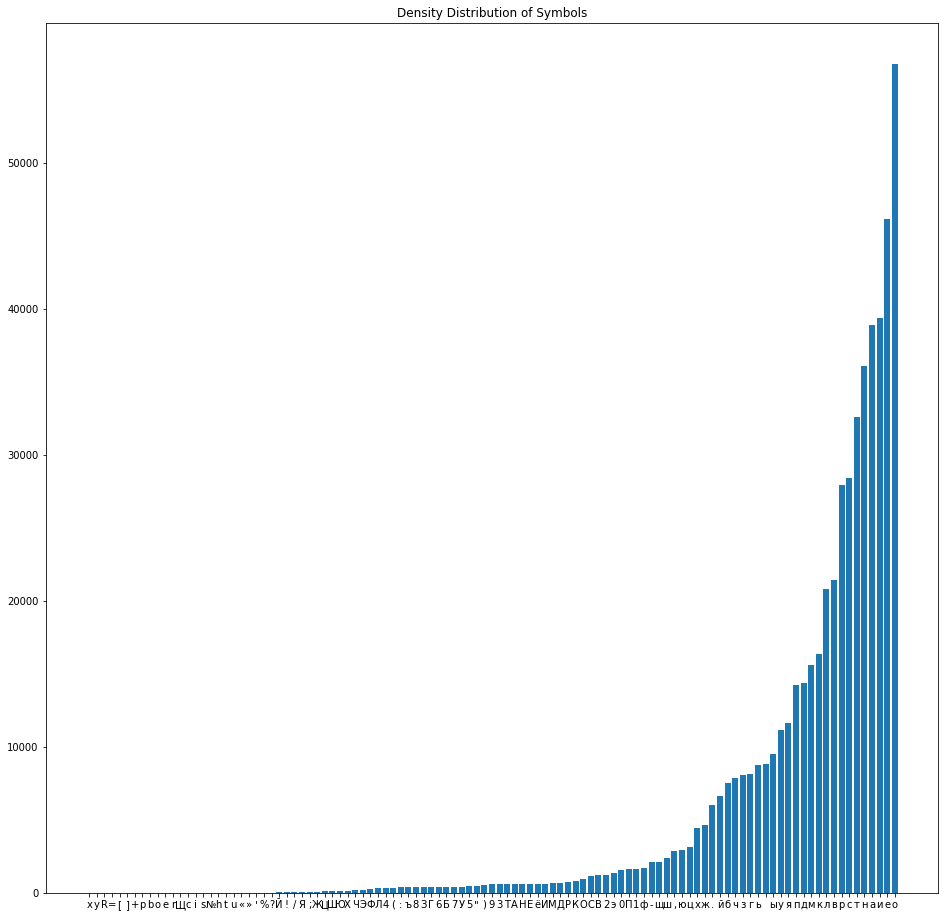

In [3]:
N = len(labels)
max_len = -1
for label in labels:
    if len(label) > max_len:
        max_len = len(label)

counter_length = {}
for lable in labels:
    L = len(lable)
    if L not in counter_length.keys():
        counter_length[L] = 0
    counter_length[L] += 1
    
counter_exps = Counter(labels)
counter_exps = dict(sorted(counter_exps.items(), key=lambda item: item[1]))
counter_chars = Counter(''.join(labels))
counter_chars = dict(sorted(counter_chars.items(), key=lambda item: item[1]))
print(
    'Size of dataset: {}\nMax length of expression: {}\nThe most common char: {}\nThe least common char: {}\nThe most common expression: {}\nThe least common expression: {}'.format( \
        N, max_len, list(counter_chars.items())[-1], list(counter_chars.items())[0], list(counter_exps.items())[-1], list(counter_exps.items())[0]))


plt.figure(figsize=(16, 16))
plt.title('Density Distribution of Symbols')
plt.bar(counter_chars.keys(), [counter_chars[key] for key in counter_chars.keys()])

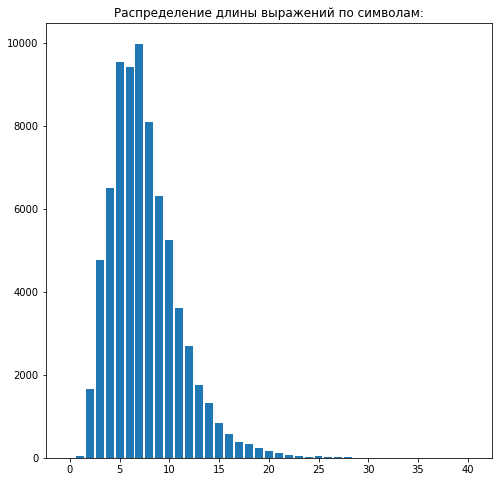

In [4]:
plt.figure(figsize=(8, 8))
plt.title('Распределение длины выражений по символам:')
plt.bar(counter_length.keys(), [counter_length[key] for key in counter_length.keys()]);

Сель
китов
процессе
перепонки.
направленности
героев. К
характерны
круге
Самые молодые
стояние
"мор-псих, боев качест"
толки
реализацию
кость
защиты
09.01.10
спальное
автора,
числами.
свойствами


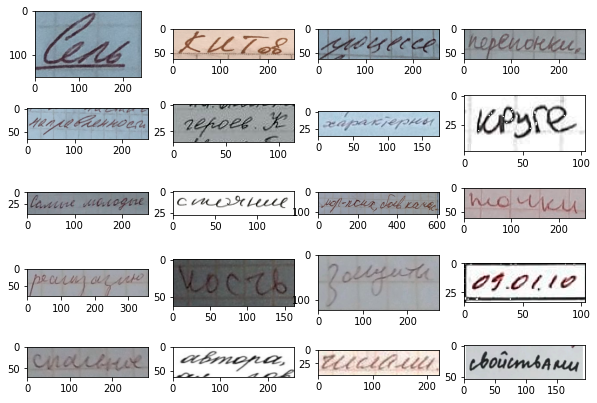

In [6]:
N_examples = 20
examples = []

for k in range(N_examples):
    i = random.randint(0, len(images))
    img = images[i]
    trans = labels[i]
    examples.append([img,trans])
fig = plt.figure(figsize=(10, 10))
rows = int(N_examples / 4) + 2
columns = int(N_examples / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0])
    print(exp[1])

## Инстанс

In [2]:
!pip install Augmentor editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import random
import string
import math
from collections import Counter
from time import time

import Augmentor
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, LeakyReLU
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import editdistance
from tqdm import tqdm

## Пути и константы

In [17]:
DIR = './' # work directory
PATH_TEST_DIR = '../input/cyrillic-handwriting-dataset/test/'
PATH_TEST_LABELS =  '../input/cyrillic-handwriting-dataset/test.tsv'
PATH_TRAIN_DIR =  '../input/cyrillic-handwriting-dataset/train/'
PATH_TRAIN_LABELS =  '../input/cyrillic-handwriting-dataset/train.tsv'
PATH_VAL_DIR = '../input/fields-validation/fields_val/fields_val/'
PATH_VAL_LABELS = '../input/fields-validation/fields_val.tsv'
PREDICT_PATH = "../input/cyrillic-handwriting-dataset/test/"
CHECKPOINT_PATH = DIR
WEIGHTS_PATH =  "../input/simple-and-efficient-transformer-ocr-weights/ocr_transformer_4h2l_simple_conv_64x256.pt"
PATH_TEST_RESULTS = DIR+'/test_result.tsv'
TRAIN_LOG = DIR+'train_log.tsv'

## Пути и константы для Fine-Tuning

In [5]:
DIR = './' # work directory
PATH_TEST_DIR = '../input/fields-transformer/fields_transf_test/fields_transf_test/'
PATH_TEST_LABELS = '../input/fields-transformer/fields_transf_test.tsv'
PATH_TRAIN_DIR = '../input/fields-transformer/fields_transf_train/fields_transf_train/'
PATH_TRAIN_LABELS = '../input/fields-transformer/fields_transf_train.tsv'
PATH_VAL_DIR = '../input/fields-validation/fields_val/fields_val/'
PATH_VAL_LABELS = '../input/fields-validation/fields_val.tsv'
PREDICT_PATH = '../input/fields-transformer/fields_transf_test/fields_transf_test/'
CHECKPOINT_PATH = DIR
WEIGHTS_PATH =  "../input/simple-and-efficient-transformer-ocr-weights/ocr_transformer_4h2l_simple_conv_64x256.pt"
PATH_TEST_RESULTS = DIR+'/test_result.tsv'
TRAIN_LOG = DIR+'train_log.tsv'

## Конфиг

In [6]:
### MODEL ### 
MODEL = 'model2'
HIDDEN = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
N_HEADS = 4
LENGTH = 42
ALPHABET = ['PAD', 'SOS', ' ', '!', '"', '%', '(', ')', ',', '-', '.', '/',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
            '[', ']', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И',
            'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х',
            'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е',
            'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т',
            'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            'ё', 'EOS']
            
### TRAINING ###
BATCH_SIZE = 16
DROPOUT = 0.2
N_EPOCHS = 128
CHECKPOINT_FREQ = 10 # save checkpoint every 10 epochs
DEVICE = 'cuda:0' # or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
SCHUDULER_ON = True # "ReduceLROnPlateau"
PATIENCE = 5 # for ReduceLROnPlateau
OPTIMIZER_NAME = 'Adam' # or "SGD"
LR = 2e-6

### TESTING ###
CASE = False # is case taken into account or not while evaluating
PUNCT = False # are punctuation marks taken into account

### INPUT IMAGE PARAMETERS ###
WIDTH = 256
HEIGHT = 64
CHANNELS = 1 # 3 channels if model1

## Утилиты

In [7]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.scale = torch.nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x) 

    
# convert images and labels into defined data structures
def process_data(image_dir, labels_dir, ignore=[]):
    """
    params
    ---
    image_dir : str
      path to directory with images
    labels_dir : str
      path to tsv file with labels
    returns
    ---
    img2label : dict
      keys are names of images and values are correspondent labels
    chars : list
      all unique chars used in data
    all_labels : list
    """

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split('\t')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char)
        except:
            print('ValueError:', x)
            pass

    all_labels = sorted(list(set(list(img2label.values()))))
    chars.sort()
    chars = ['PAD', 'SOS'] + chars + ['EOS']

    return img2label, chars, all_labels


# TRANSLATE INDICIES TO TEXT
def indicies_to_text(indexes, idx2char):
    text = "".join([idx2char[i] for i in indexes])
    text = text.replace('EOS', '').replace('PAD', '').replace('SOS', '')
    return text


# COMPUTE CHARACTER ERROR RATE
def char_error_rate(p_seq1, p_seq2):
    """
    params
    ---
    p_seq1 : str
    p_seq2 : str
    returns
    ---
    cer : float
    """
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))


# RESIZE AND NORMALIZE IMAGE
def process_image(img):
    """
    params:
    ---
    img : np.array
    returns
    ---
    img : np.array
    """
    w, h, _ = img.shape
    new_w = HEIGHT
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = WIDTH
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img


# GENERATE IMAGES FROM FOLDER
def generate_data(img_paths):
    """
    params
    ---
    names : list of str
        paths to images
    returns
    ---
    data_images : list of np.array
        images in np.array format
    """
    data_images = []
    for path in tqdm(img_paths):
        img = np.asarray(Image.open(path).convert('RGB'))
        try:
            img = process_image(img)
            data_images.append(img.astype('uint8'))
        except:
            print(path)
            img = process_image(img)
    return data_images


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def evaluate(model, criterion, loader, case=True, punct=True):
    """
    params
    ---
    model : nn.Module
    criterion : nn.Object
    loader : torch.utils.data.DataLoader

    returns
    ---
    epoch_loss / len(loader) : float
        overall loss
    """
    model.eval()
    metrics = {'loss': 0, 'wer': 0, 'cer': 0}
    result = {'true': [], 'predicted': [], 'wer': []}
    with torch.no_grad():
        for (src, trg) in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            logits = model(src, trg[:-1, :])
            loss = criterion(logits.view(-1, logits.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
            out_indexes = model.predict(src)
            
            true_phrases = [indicies_to_text(trg.T[i][1:], ALPHABET) for i in range(BATCH_SIZE)]
            pred_phrases = [indicies_to_text(out_indexes[i], ALPHABET) for i in range(BATCH_SIZE)]
            
            if not case:
                true_phrases = [phrase.lower() for phrase in true_phrases]
                pred_phrases = [phrase.lower() for phrase in pred_phrases]
            if not punct:
                true_phrases = [phrase.translate(str.maketrans('', '', string.punctuation))\
                                for phrase in true_phrases]
                pred_phrases = [phrase.translate(str.maketrans('', '', string.punctuation))\
                                for phrase in pred_phrases]
            
            metrics['loss'] += loss.item()
            metrics['cer'] += sum([char_error_rate(true_phrases[i], pred_phrases[i]) \
                        for i in range(BATCH_SIZE)])/BATCH_SIZE
            metrics['wer'] += sum([int(true_phrases[i] != pred_phrases[i]) \
                        for i in range(BATCH_SIZE)])/BATCH_SIZE

            for i in range(len(true_phrases)):
                result['true'].append(true_phrases[i])
                result['predicted'].append(pred_phrases[i])
                result['wer'].append(char_error_rate(true_phrases[i], pred_phrases[i]))

    for key in metrics.keys():
        metrics[key] /= len(loader)

    return metrics, result


# MAKE PREDICTION
def prediction(model, test_dir, char2idx, idx2char):
    """
    params
    ---
    model : nn.Module
    test_dir : str
        path to directory with images
    char2idx : dict
        map from chars to indicies
    id2char : dict
        map from indicies to chars

    returns
    ---
    preds : dict
        key : name of image in directory
        value : dict with keys ['p_value', 'predicted_label']
    """
    preds = {}
    os.makedirs('/output', exist_ok=True)
    model.eval()

    with torch.no_grad():
        for filename in os.listdir(test_dir):
            img = Image.open(test_dir + filename).convert('RGB')

            img = process_image(np.asarray(img)).astype('uint8')
            img = img / img.max()
            img = np.transpose(img, (2, 0, 1))

            src = torch.FloatTensor(img).unsqueeze(0).to(DEVICE)
            if CHANNELS == 1:
                src = transforms.Grayscale(CHANNELS)(src)
            out_indexes = model.predict(src)
            pred = indicies_to_text(out_indexes[0], idx2char)
            preds[filename] = pred

    return preds


class ToTensor(object):
    def __init__(self, X_type=None, Y_type=None):
        self.X_type = X_type

    def __call__(self, X):
        X = X.transpose((2, 0, 1))
        X = torch.from_numpy(X)
        if self.X_type is not None:
            X = X.type(self.X_type)
        return X


def log_config(model):
    print('transformer layers: {}'.format(model.enc_layers))
    print('transformer heads: {}'.format(model.transformer.nhead))
    print('hidden dim: {}'.format(model.decoder.embedding_dim))
    print('num classes: {}'.format(model.decoder.num_embeddings))
    print('backbone: {}'.format(model.backbone_name))
    print('dropout: {}'.format(model.pos_encoder.dropout.p))
    print(f'{count_parameters(model):,} trainable parameters')


def log_metrics(metrics, path_to_logs=None):
    if path_to_logs != None:
        f = open(path_to_logs, 'a')
    if metrics['epoch'] == 1:
        if path_to_logs != None:
            f.write('Epoch\tTrain_loss\tValid_loss\tCER\tWER\tTime\n')
        print('Epoch   Train_loss   Valid_loss   CER   WER    Time    LR')
        print('-----   -----------  ----------   ---   ---    ----    ---')
    print('{:02d}       {:.2f}         {:.2f}       {:.2f}   {:.2f}   {:.2f}   {:.7f}'.format(\
        metrics['epoch'], metrics['train_loss'], metrics['loss'], metrics['cer'], \
        metrics['wer'], metrics['time'], metrics['lr']))
    if path_to_logs != None:
        f.write(str(metrics['epoch'])+'\t'+str(metrics['train_loss'])+'\t'+str(metrics['loss'])+'\t'+str(metrics['cer'])+'\t'+str(metrics['wer'])+'\t'+str(metrics['time'])+'\n')
        f.close()
        

# plot images
def show_img_grid(images, labels, N):
    n = int(N**(0.5))
    k = 0
    f, axarr = plt.subplots(n,n,figsize=(10,10))
    for i in range(n):
        for j in range(n):
            axarr[i,j].set_title(labels[k])
            axarr[i,j].imshow(images[k])
            k += 1

## Набор данных

In [8]:
# text to array of indicies
def text_to_labels(s, char2idx):
    return [char2idx['SOS']] + [char2idx[i] for i in s if i in char2idx.keys()] + [char2idx['EOS']]

# store list of images' names (in directory) and does some operations with images
class TextLoader(torch.utils.data.Dataset):
    def __init__(self, images_name, labels, transforms, char2idx, idx2char):
        """
        params
        ---
        images_name : list
            list of names of images (paths to images)
        labels : list
            list of labels to correspondent images from images_name list
        char2idx : dict
        idx2char : dict
        """
        self.images_name = images_name
        self.labels = labels
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.transform = transforms

    def _transform(self, X):
        j = np.random.randint(0, 3, 1)[0]
        if j == 0:
            return self.transform(X)
        if j == 1:
            return tt(ld(vignet(X)))
        if j == 2:
            return tt(ld(un(X)))
            

    # shows some stats about dataset
    def get_info(self):
        N = len(self.labels)
        max_len = -1
        for label in self.labels:
            if len(label) > max_len:
                max_len = len(label)
        counter = Counter(''.join(self.labels))
        counter = dict(sorted(counter.items(), key=lambda item: item[1]))
        print(
            'Size of dataset: {}\nMax length of expression: {}\nThe most common char: {}\nThe least common char: {}'.format( \
                N, max_len, list(counter.items())[-1], list(counter.items())[0]))

    def __getitem__(self, index):
        img = self.images_name[index]
        img = self.transform(img)
        img = img / img.max()
        img = img ** (random.random() * 0.7 + 0.6)

        label = text_to_labels(self.labels[index], self.char2idx)
        return (torch.FloatTensor(img), torch.LongTensor(label))

    def __len__(self):
        return len(self.labels)


# MAKE TEXT TO BE THE SAME LENGTH
class TextCollate():
    def __call__(self, batch):
        x_padded = []
        y_padded = torch.LongTensor(LENGTH, len(batch))
        y_padded.zero_()

        for i in range(len(batch)):
            x_padded.append(batch[i][0].unsqueeze(0))
            y = batch[i][1]
            y_padded[:y.size(0), i] = y

        x_padded = torch.cat(x_padded)
        return x_padded, y_padded
    

p = Augmentor.Pipeline()
p.shear(max_shear_left=2, max_shear_right=2, probability=0.7)
p.random_distortion(probability=1.0, grid_width=3, grid_height=3, magnitude=11)

TRAIN_TRANSFORMS = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(CHANNELS),
            p.torch_transform(),  # random distortion and shear
            transforms.ColorJitter(contrast=(0.5,1),saturation=(0.5,1)),
            transforms.RandomRotation(degrees=(-9, 9)),
            transforms.RandomAffine(10, None, [0.6 ,1] ,3 ,fill=255),
            #transforms.transforms.GaussianBlur(3, sigma=(0.1, 1.9)),
            transforms.ToTensor()
        ])

TEST_TRANSFORMS = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(CHANNELS),
            transforms.ToTensor()
        ])

In [27]:
VAL_TRANSFORMS = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(CHANNELS),
            transforms.ToTensor()
        ])

## Модель

In [9]:
class TransformerModel(nn.Module):
    def __init__(self, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.backbone_name = 'conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)'

        self.conv0 = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv3 = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv5 = Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = Conv2d(512, 512, kernel_size=(2, 1), stride=(1, 1))
        
        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)

        self.bn0 = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn1 = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn3 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn4 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn5 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn6 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.activ = LeakyReLU()

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout)

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None
        
        log_config(self)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=DEVICE), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)
    
    def _get_features(self, src):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        returns
        ---
        x : Tensor : [W,B,CH]
        '''
        x = self.activ(self.bn0(self.conv0(src)))
        x = self.pool1(self.activ(self.bn1(self.conv1(x))))
        x = self.activ(self.bn2(self.conv2(x)))
        x = self.pool3(self.activ(self.bn3(self.conv3(x))))
        x = self.activ(self.bn4(self.conv4(x)))
        x = self.pool5(self.activ(self.bn5(self.conv5(x))))
        x = self.activ(self.bn6(self.conv6(x)))
        x = x.permute(0, 3, 1, 2).flatten(2).permute(1, 0, 2)
        return x

    def predict(self, batch):
        '''
        params
        ---
        batch : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        
        returns
        ---
        result : List [64, -1] : [B, -1]
            preticted sequences of tokens' indexes
        '''
        result = []
        for item in batch:
            x = self._get_features(item.unsqueeze(0))
            memory = self.transformer.encoder(self.pos_encoder(x))
            out_indexes = [ALPHABET.index('SOS'), ]
            for i in range(100):
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(DEVICE)
                output = self.fc_out(self.transformer.decoder(self.pos_decoder(self.decoder(trg_tensor)), memory))

                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == ALPHABET.index('EOS'):
                    break
            result.append(out_indexes)
        return result

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device) 

        x = self._get_features(src)
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x)
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)

        return output

## Обучение

In [10]:
def train(model, optimizer, criterion, train_loader):
    """
    params
    ---
    model : nn.Module
    optimizer : nn.Object
    criterion : nn.Object
    train_loader : torch.utils.data.DataLoader
    returns
    ---
    epoch_loss / len(train_loader) : float
        overall loss
    """
    model.train()
    epoch_loss = 0
    for src, trg in train_loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg[:-1, :])

        loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


# GENERAL FUNCTION FROM TRAINING AND VALIDATION
def fit(model, optimizer, scheduler, criterion, train_loader, val_loader, start_epoch=0, end_epoch=24):
    metrics = []
    for epoch in range(start_epoch, end_epoch):
        epoch_metrics = {}
        start_time = time()
        train_loss = train(model, optimizer, criterion, train_loader)
        end_time = time()
        epoch_metrics, _ = evaluate(model, criterion, val_loader)
        epoch_metrics['train_loss'] = train_loss
        epoch_metrics['epoch'] = epoch
        epoch_metrics['time'] = end_time - start_time
        epoch_metrics['lr'] = optimizer.param_groups[0]["lr"]
        metrics.append(epoch_metrics)
        log_metrics(epoch_metrics, TRAIN_LOG)
        if scheduler != None:
            scheduler.step(epoch_metrics['loss'])
    return metrics

## Загрузка обучающих данных

In [34]:
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

char2idx = {char: idx for idx, char in enumerate(ALPHABET)}
idx2char = {idx: char for idx, char in enumerate(ALPHABET)}

print(f"loading dataset {PATH_TRAIN_DIR} ...")
img2label, _, all_words = process_data(PATH_TRAIN_DIR, PATH_TRAIN_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_train = generate_data(img_names)
y_train = labels

train_dataset = TextLoader(X_train, y_train, TRAIN_TRANSFORMS, char2idx, idx2char)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

print(f"loading dataset {PATH_TEST_DIR} ...")
img2label, _, all_words = process_data(PATH_TEST_DIR, PATH_TEST_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_test = generate_data(img_names)
y_test = labels

test_dataset = TextLoader(X_test, y_test, TEST_TRANSFORMS, char2idx ,idx2char)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

print("TRAIN DATASET:")
train_dataset.get_info()
print("\nTEST DATASET:")
test_dataset.get_info()

loading dataset ../input/cyrillic-handwriting-dataset/train/ ...


100%|██████████| 72286/72286 [03:50<00:00, 313.04it/s]


loading dataset ../input/cyrillic-handwriting-dataset/test/ ...


100%|██████████| 1544/1544 [00:05<00:00, 302.36it/s]


TRAIN DATASET:
Size of dataset: 72286
Max length of expression: 40
The most common char: ('о', 55414)
The least common char: ('x', 1)

TEST DATASET:
Size of dataset: 1544
Max length of expression: 22
The most common char: ('о', 1321)
The least common char: ('Й', 1)


## Загрузка валидационного датасета, рабочие данные

In [28]:
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

char2idx = {char: idx for idx, char in enumerate(ALPHABET)}
idx2char = {idx: char for idx, char in enumerate(ALPHABET)}

print(f"loading dataset {PATH_VAL_DIR} ...")
img2label, _, all_words = process_data(PATH_VAL_DIR, PATH_VAL_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_val = generate_data(img_names)
y_val = labels

val_dataset = TextLoader(X_val, y_val, VAL_TRANSFORMS, char2idx ,idx2char)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())
print("VAL DATASET:")
val_dataset.get_info()

loading dataset ../input/fields-validation/fields_val/fields_val/ ...
ValueError: ['']


100%|██████████| 61/61 [00:00<00:00, 140.59it/s]

VAL DATASET:
Size of dataset: 61
Max length of expression: 34
The most common char: (' ', 91)
The least common char: ('Н', 1)


In [ ]:
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                          nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
optimizer = torch.optim.__getattribute__(OPTIMIZER_NAME)(model.parameters(), lr=LR)

if SCHUDULER_ON:
    scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE)
else:
    scheduler = None

print(f'checkpoints are saved in {CHECKPOINT_PATH} every {CHECKPOINT_FREQ} epochs')

# Обучение (модель сохранена, код закомментирован)
for epoch in range(1, N_EPOCHS, CHECKPOINT_FREQ):
     fit(model, optimizer, scheduler, criterion, train_loader, test_loader, epoch, epoch+CHECKPOINT_FREQ)
     torch.save(model.state_dict(), CHECKPOINT_PATH+'checkpoint_{}.pt'.format(epoch+CHECKPOINT_FREQ))

def save_trained_model(model, path):
    torch.save(model.state_dict(), path)

trained_model_path = '../input/trained_ocr_transformer/ocr_transformer.pth'

save_trained_model(model, trained_model_path)

## Тест обучающие данные

In [35]:
%%time
# load weights
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                          nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)
model.load_state_dict(torch.load(WEIGHTS_PATH))

# evaluate
criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
metrics, result = evaluate(model, criterion, test_loader, case=CASE, punct=PUNCT)

if PATH_TEST_RESULTS != None:
    f = open(PATH_TEST_RESULTS, 'w')
    f.write("true\tpredicted\twer\n")
    for i in range(len(result['true'])): 
        f.write(result['true'][i]+\
            '\t'+result['predicted'][i]+\
            '\t'+str(result['wer'][i])+'\n')
print(f'PUNCT: {PUNCT}, CASE: {CASE}')
print(metrics)

transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.2
19,838,174 trainable parameters
PUNCT: False, CASE: False
{'loss': 0.35087016492616385, 'wer': 0.3600260416666667, 'cer': 0.08418286607481228}
CPU times: user 53.3 s, sys: 77.1 ms, total: 53.4 s
Wall time: 51.8 s


In [36]:
# read predictions and show it
df = pd.read_csv(PATH_TEST_RESULTS, sep='\t', quoting=3)
df.head(10)

,true,predicted,wer
0,разностная,разкостная,0.100000
1,стипендию получаю,стипендию получаю,0.000000
2,05041999г,05041999г,0.000000
3,схема,стого,0.800000
4,объяснительная,объяснительное,0.142857
5,адвокатов,адвоматов,0.111111
6,санктпетербург,сомкин пемертург,0.437500
7,метод,метод,0.000000
8,одиннадцатого,одинадцатого,0.076923
9,тензора,тензора,0.000000


In [37]:
50 / len(df)

0.03380662609871535

In [38]:
preds = prediction(model, PREDICT_PATH, char2idx, idx2char)

f = open(DIR+'/predictions.tsv', 'w')
f.write('filename\tprediction\n')
for item in preds.items():
    f.write(item[0]+'\t'+item[1]+'\n')
f.close()
print(f'predictions are saved in {DIR}predictions.tsv')

predictions are saved in ./predictions.tsv


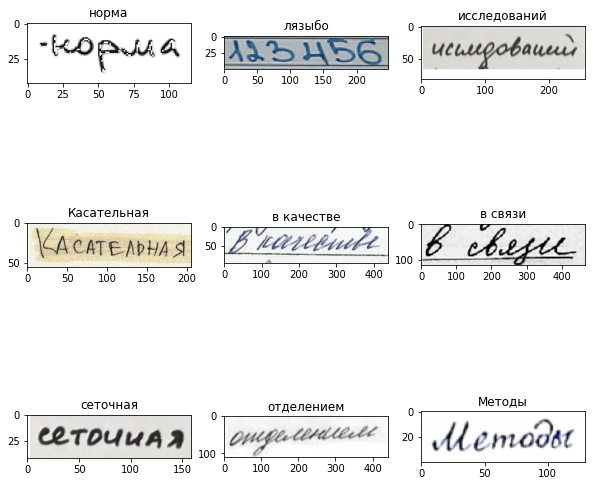

In [40]:
df = pd.read_csv(DIR+'/predictions.tsv', sep='\t', quoting=3)
N = 9
images = []
labels = []
for i in range(N):
    idx = random.randint(0, len(df))
    image_path = PATH_TEST_DIR + df.iloc[idx]['filename']
    predicted_label = df.iloc[idx]['prediction']

    images.append(Image.open(image_path))
    labels.append(predicted_label)

show_img_grid(images, labels, N)

## Работа предобученной модели на валидационных данных рабочего датасета

In [53]:
%%time
# load weights
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                          nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)
model.load_state_dict(torch.load(WEIGHTS_PATH))

# evaluate
criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
metrics, result = evaluate(model, criterion, val_loader, case=CASE, punct=PUNCT)

if PATH_TEST_RESULTS is not None:
    with open(PATH_TEST_RESULTS, 'w') as f:
        f.write("true\tpredicted\twer\n")
        for true_text, predicted_text, wer_value in zip(result['true'], result['predicted'], result['wer']):
            f.write(f"{true_text}\t{predicted_text}\t{str(wer_value)}\n")

print(f'PUNCT: {PUNCT}, CASE: {CASE}')
print(metrics)

transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.2
19,838,174 trainable parameters
PUNCT: False, CASE: False
{'loss': 1.8676925500233967, 'wer': 0.9166666666666666, 'cer': 0.3628234143045097}
CPU times: user 2.91 s, sys: 21.4 ms, total: 2.93 s
Wall time: 2.83 s


In [56]:
# read predictions and show it
df = pd.read_csv(PATH_TEST_RESULTS, sep='\t', quoting=3)
df.head(61)

,true,predicted,wer
0,имя иван,имя иван,0.000000
1,имя майа,имя мый,0.250000
2,фамилия букин,функция буки,0.384615
3,мобильный телефон 89858100907,монгона прон в 851907,0.551724
4,имя захар,имя захар,0.000000
5,мобильный телефон 89091614858,подниматрона 199 1619 г,0.689655
6,имя елизавета,та елизавета,0.230769
7,фамилия сычева,ожна сычева,0.500000
8,фамилия давлатов,от давлатов,0.437500
9,имя валерия,имя валерия,0.000000


In [45]:
preds = prediction(model, PATH_VAL_DIR, char2idx, idx2char)

f = open(DIR+'/predictions.tsv', 'w')
f.write('filename\tprediction\n')
for item in preds.items():
    f.write(item[0]+'\t'+item[1]+'\n')
f.close()
print(f'predictions are saved in {DIR}predictions.tsv')

predictions are saved in ./predictions.tsv


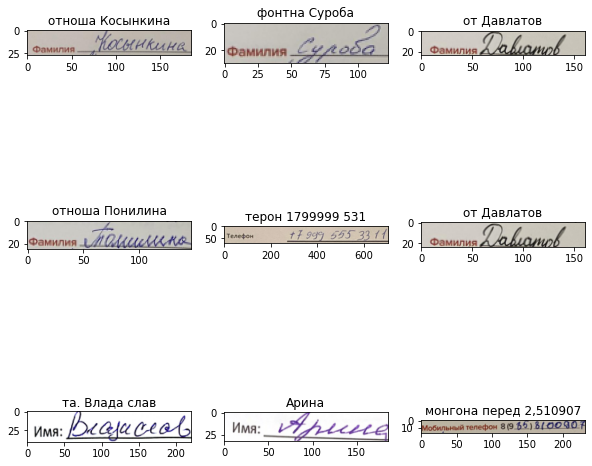

In [52]:
df = pd.read_csv(DIR+'/predictions.tsv', sep='\t', quoting=3)
N = 9
images = []
labels = []
for i in range(N):
    idx = random.randint(0, len(df))
    image_path = PATH_VAL_DIR + df.iloc[idx]['filename']
    predicted_label = df.iloc[idx]['prediction']

    images.append(Image.open(image_path))
    labels.append(predicted_label)

show_img_grid(images, labels, N)

## Вывод: 
Предобученная модель работает с полями анкет, распознает рукописный текст. Плохо понимает печатный текст, поскольку в обучающем датасете его не было. Также из-за редостаточного количества цифр плохо распознаются телефонные номера. Нужно дообучать модель на своих данных

## Fine-Tuning

In [11]:
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

char2idx = {char: idx for idx, char in enumerate(ALPHABET)}
idx2char = {idx: char for idx, char in enumerate(ALPHABET)}

print(f"loading dataset {PATH_TRAIN_DIR} ...")
img2label, _, all_words = process_data(PATH_TRAIN_DIR, PATH_TRAIN_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_train = generate_data(img_names)
y_train = labels

train_dataset = TextLoader(X_train, y_train, TRAIN_TRANSFORMS, char2idx, idx2char)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

print(f"loading dataset {PATH_TEST_DIR} ...")
img2label, _, all_words = process_data(PATH_TEST_DIR, PATH_TEST_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_test = generate_data(img_names)
y_test = labels

test_dataset = TextLoader(X_test, y_test, TEST_TRANSFORMS, char2idx ,idx2char)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

print("TRAIN DATASET:")
train_dataset.get_info()
print("\nTEST DATASET:")
test_dataset.get_info()

loading dataset ../input/fields-transformer/fields_transf_train/fields_transf_train/ ...
ValueError: ['']


100%|██████████| 2560/2560 [00:13<00:00, 188.18it/s]


loading dataset ../input/fields-transformer/fields_transf_test/fields_transf_test/ ...
ValueError: ['']


100%|██████████| 770/770 [00:05<00:00, 146.54it/s]

TRAIN DATASET:
Size of dataset: 2560
Max length of expression: 34
The most common char: (' ', 4305)
The least common char: ('/', 1)

TEST DATASET:
Size of dataset: 770
Max length of expression: 34
The most common char: ('и', 1143)
The least common char: ('Щ', 1)


In [12]:
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                          nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)

# Загрузка сохраненного состояния модели
model.load_state_dict(torch.load(WEIGHTS_PATH))

# Перевод модели в режим обучения
model.train()

transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.2
19,838,174 trainable parameters


TransformerModel(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(2, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
optimizer = torch.optim.__getattribute__(OPTIMIZER_NAME)(model.parameters(), lr=LR)

if SCHUDULER_ON:
    scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE)
else:
    scheduler = None

print(f'checkpoints are saved in {CHECKPOINT_PATH} every {CHECKPOINT_FREQ} epochs')


for epoch in range(1, N_EPOCHS, CHECKPOINT_FREQ):
     fit(model, optimizer, scheduler, criterion, train_loader, test_loader, epoch, epoch+CHECKPOINT_FREQ)
     torch.save(model.state_dict(), CHECKPOINT_PATH+'checkpoint_{}.pt'.format(epoch+CHECKPOINT_FREQ))





In [14]:
def save_trained_model(model, path):
    torch.save(model.state_dict(), path)
    
trained_model_path = DIR+'ocr_transformer.pth'


save_trained_model(model, trained_model_path)

## Тест дообученной модели

In [15]:
metrics, result = evaluate(model, criterion, test_loader, case=CASE, punct=PUNCT)

if PATH_TEST_RESULTS != None:
    f = open(PATH_TEST_RESULTS, 'w')
    f.write("true\tpredicted\twer\n")
    for i in range(len(result['true'])): 
        f.write(result['true'][i]+\
            '\t'+result['predicted'][i]+\
            '\t'+str(result['wer'][i])+'\n')
print(f'PUNCT: {PUNCT}, CASE: {CASE}')
print(metrics)

PUNCT: False, CASE: False
{'loss': 0.26466462947428226, 'wer': 0.6119791666666666, 'cer': 0.10032517041576272}


In [16]:
# read predictions and show it
df = pd.read_csv(PATH_TEST_RESULTS, sep='\t', quoting=3)
df.head(10)

,true,predicted,wer
0,фамилия мисюрев,фамилия милюрев,0.066667
1,имя юлия,имя юлия,0.000000
2,имя алена,имя алена,0.000000
3,фамилия рябова,фамилия рябова,0.000000
4,мобильный телефон 8977 9894172,мобильный телефон 8977999717,0.133333
5,мобильный телефон 8999118 56 73,мобильный телефон 89991185673,0.064516
6,фамилия горначева,фамилия горкачева,0.058824
7,мобильный телефон 81535131513,мобильный телефон 8915151513,0.137931
8,мобильный телефон 89258260567,мобильный телефон 8925826 0567,0.033333
9,имя раиса,имя ранса,0.111111


In [17]:
preds = prediction(model, PREDICT_PATH, char2idx, idx2char)

f = open(DIR+'/predictions.tsv', 'w')
f.write('filename\tprediction\n')
for item in preds.items():
    f.write(item[0]+'\t'+item[1]+'\n')
f.close()
print(f'predictions are saved in {DIR}predictions.tsv')

predictions are saved in ./predictions.tsv


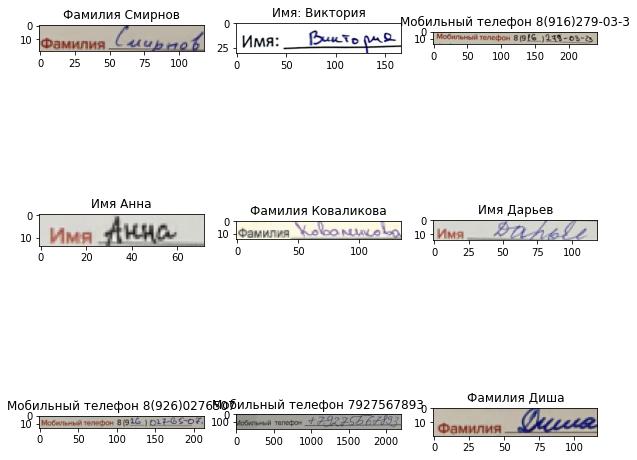

In [26]:
# Загрузка данных
df = pd.read_csv(DIR + '/predictions.tsv', sep='\t', quoting=3)

# Проверка на случай, если DataFrame пустой
if df.empty:
    raise ValueError("DataFrame пустой. Проверьте файл с данными.")

N = 9  # Количество изображений
images = []
labels = []

# Генерация случайных индексов и добавление изображений и меток
for i in range(N):
    idx = random.randint(0, len(df) - 1)  # Исправлено, чтобы индекс не выходил за пределы
    image_path = PATH_TEST_DIR + df.iloc[idx]['filename']
    predicted_label = df.iloc[idx]['prediction']

    images.append(Image.open(image_path))
    labels.append(predicted_label)

# Отображение изображений с метками
show_img_grid(images, labels, N)

## Работа дообученной модели на валидационном датасете

In [29]:
metrics, result = evaluate(model, criterion, val_loader, case=CASE, punct=PUNCT)

if PATH_TEST_RESULTS is not None:
    with open(PATH_TEST_RESULTS, 'w') as f:
        f.write("true\tpredicted\twer\n")
        for true_text, predicted_text, wer_value in zip(result['true'], result['predicted'], result['wer']):
            f.write(f"{true_text}\t{predicted_text}\t{str(wer_value)}\n")

print(f'PUNCT: {PUNCT}, CASE: {CASE}')
print(metrics)

PUNCT: False, CASE: False
{'loss': 0.09351569662491481, 'wer': 0.3541666666666667, 'cer': 0.030702231257251977}


In [30]:
# read predictions and show it
df = pd.read_csv(PATH_TEST_RESULTS, sep='\t', quoting=3)
df.head(61)

,true,predicted,wer
0,телефон 7 9636263868,телефон 7 9636263868,0.000000
1,телефон 7 999 555 33 11,телефон 7 999 555 331,0.086957
2,фамилия сычева,фамилия сычева,0.000000
3,фамилия шкляр,фамилия олекляр,0.200000
4,имя майа,имя майа,0.000000
5,телефон 7905 3965504,телефон 7905 396504,0.050000
6,телефон 8926 3481526,телефон 89263481526,0.050000
7,фамилия медведева,фамилия хирведева,0.176471
8,фамилия агафонова,фамилия агаронова,0.058824
9,мобильный телефон 7 916 311 82 15,мобильный телефон 7 916 311 8215,0.030303


In [31]:
preds = prediction(model, PATH_VAL_DIR, char2idx, idx2char)

f = open(DIR+'/predictions.tsv', 'w')
f.write('filename\tprediction\n')
for item in preds.items():
    f.write(item[0]+'\t'+item[1]+'\n')
f.close()
print(f'predictions are saved in {DIR}predictions.tsv')

predictions are saved in ./predictions.tsv


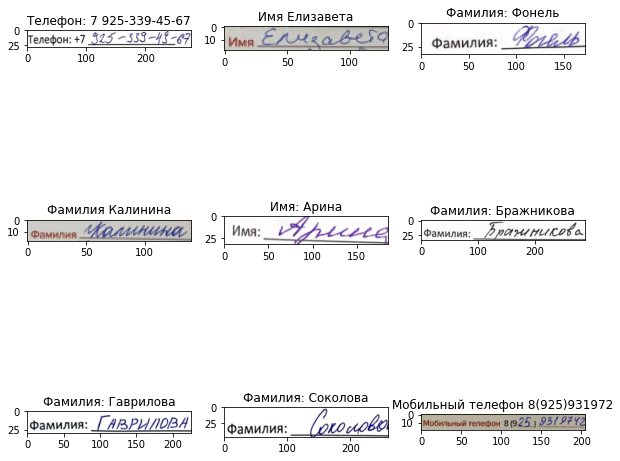

In [33]:
df = pd.read_csv(DIR+'/predictions.tsv', sep='\t', quoting=3)
N = 9
images = []
labels = []
for i in range(N):
    idx = random.randint(0, len(df))
    image_path = PATH_VAL_DIR + df.iloc[idx]['filename']
    predicted_label = df.iloc[idx]['prediction']

    images.append(Image.open(image_path))
    labels.append(predicted_label)

show_img_grid(images, labels, N)

## Вывод:
Дообученная модель начала хорошо справляться с машинным шрифтом, очень хорошо распознаются имена и фамилии, Удовлетворительно начали распозноваться номера телефонов. Чтобы поднять качество распознования номеров, необходимо увеличивать обучающий датасет. 